# Ques 2
 **Audio Reconstruction** - Pick a 5-second audio sample of your liking. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from time $(t)$ to amplitude $(A)$, where $t$ is the time point, and $A$ is the audio amplitude at that time. Play the reconstructed audio and the original audio to demonstrate reconstruction. Calculate the Root Mean Squared Error (RMSE) and Signal-to-Noise Ratio (SNR) to evaluate the reconstruction.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.linear_model import LinearRegression
import torchaudio
from IPython.display import Audio,display

In [2]:
waveform,sample_rate = torchaudio.load("/kaggle/input/audio-file/Taqdeer.mp3")
# Loading the audio
waveform = waveform.mean(0)
# Converting stereo(2 channels) to mono(1 channel) by taking mean of 2 channels
original_audio = waveform[:5*sample_rate]
# Trimming to first 5 seconds

In [4]:
display(Audio(original_audio,rate=sample_rate))# Displaying the original audio

In [6]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

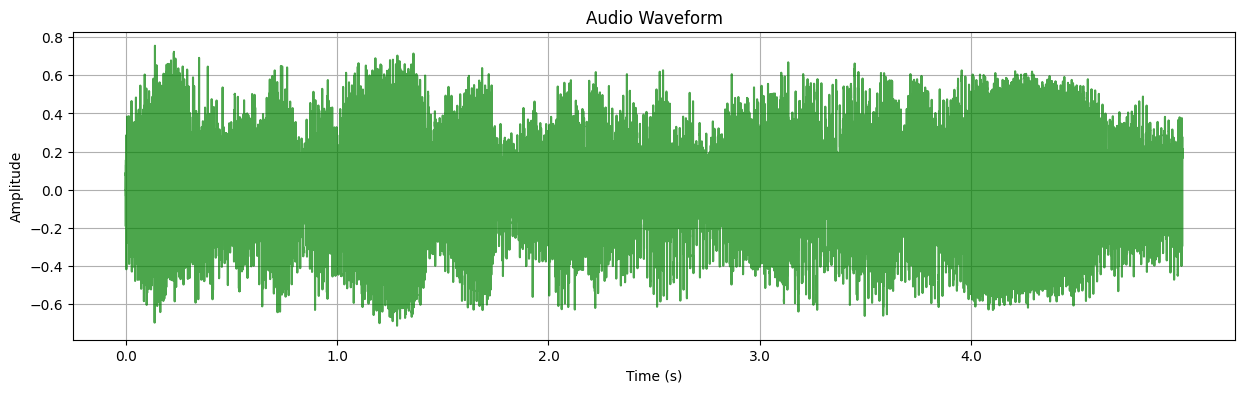

In [7]:
audio_plot(original_audio,sample_rate,"green","Audio Waveform")

In [9]:
X = torch.arange(0, len(original_audio)).unsqueeze(1).float()
X = X / X.max() * 300 - 150 # Converting 0 to 220500 points into [-150,150]
print(X.shape)
print(X)

torch.Size([220500, 1])
tensor([[-150.0000],
        [-149.9986],
        [-149.9973],
        ...,
        [ 149.9973],
        [ 149.9986],
        [ 150.0000]])


In [10]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Setting a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 42)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

In [11]:
from sklearn.metrics import mean_squared_error
def calculate_metrics(original_signal, reconstructed_signal):
    rmse = np.sqrt(mean_squared_error(original_signal, reconstructed_signal))
    snr = 10 * np.log10(np.sum(original_signal ** 2) / np.sum((original_signal - reconstructed_signal) ** 2))
    return rmse, snr

In [12]:
num_features = 6000
sigma = 0.025

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([220500, 6000])
tensor([[ 0.0182,  0.0007,  0.0074,  ..., -0.0075, -0.0181,  0.0035],
        [ 0.0182,  0.0008,  0.0080,  ..., -0.0086, -0.0181,  0.0046],
        [ 0.0181,  0.0010,  0.0085,  ..., -0.0096, -0.0180,  0.0057],
        ...,
        [-0.0103,  0.0077,  0.0055,  ..., -0.0122,  0.0023,  0.0090],
        [-0.0099,  0.0078,  0.0061,  ..., -0.0130,  0.0019,  0.0100],
        [-0.0094,  0.0079,  0.0067,  ..., -0.0138,  0.0014,  0.0109]])


In [13]:
model = LinearRegression()
model.fit(X_rff.numpy(), original_audio)

pred_audio = model.predict(X_rff.numpy())
print(pred_audio.shape)

(220500,)


In [14]:
RMSE,SNR = calculate_metrics(original_audio.numpy(),pred_audio)
print(f"RMSE: {RMSE:.4f}")
print(f"SNR: {SNR:.4f} dB")

RMSE: 0.0971
SNR: 8.1404 dB


In [15]:
L2_norm=np.linalg.norm(pred_audio - original_audio.numpy())
L1_norm=np.linalg.norm((pred_audio - original_audio.numpy()), ord = 1)
print(f"L1 Norm: {L1_norm}")
print(f"L2 Norm: {L2_norm}")

L1 Norm: 17017.3984375
L2 Norm: 45.5816535949707


In [16]:
print("Original Audio:")
display(Audio(original_audio, rate=sample_rate))  

print("Predicted Audio:")
display(Audio(pred_audio, rate=sample_rate))

Original Audio:


Predicted Audio:


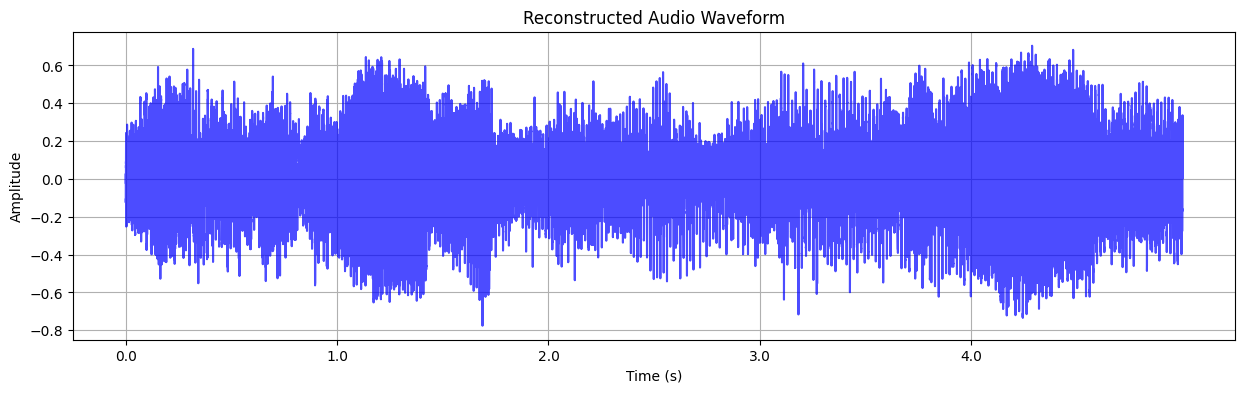

In [17]:
audio_plot(pred_audio, sample_rate, 'blue', 'Reconstructed Audio Waveform')

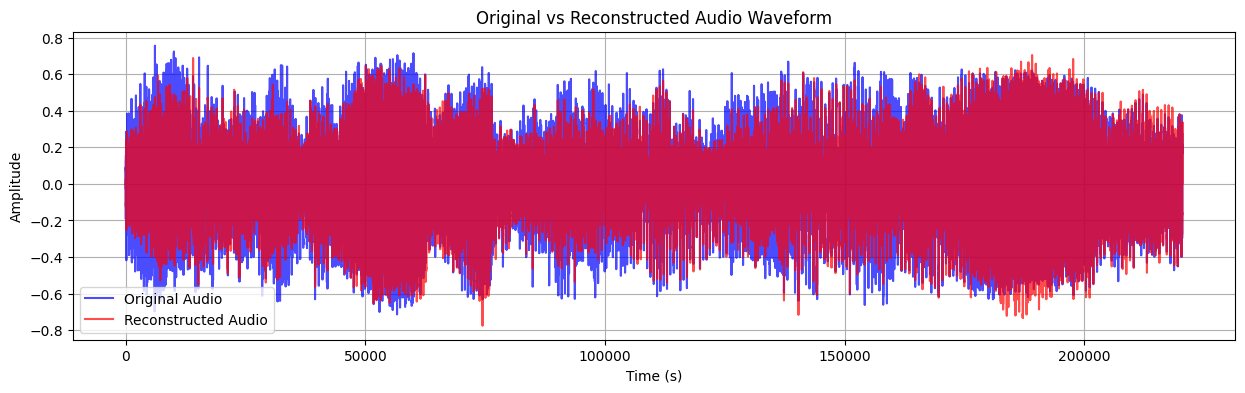

In [18]:
plt.figure(figsize=(15, 4))
plt.plot(original_audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()